**My EDA**

In [20]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk.util import ngrams
nltk.download('stopwords')
nltk.download('punkt')
from bs4 import BeautifulSoup
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

# Предобработка текста

In [21]:
result_data = pd.read_parquet('/kaggle/input/books-eng/result.pq')

In [ ]:
result_data.shape

In [ ]:
result_data.head()

In [ ]:
result_data.groupby(by='author').count()

In [22]:
data_1000 = result_data.iloc[:1000]

In [23]:
data_1000['text'] = data_1000['text'].str.replace(r'^[\r\n]+|[\r\n]+$', '', regex=True)

/tmp/ipykernel_30/461713334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1000['text'] = data_1000['text'].str.replace(r'^[\r\n]+|[\r\n]+$', '', regex=True)


In [24]:
data_1000.head(3)

,author,author_sn,title,text,FileName,is_gutenberg
4878,A_A_Milne,Milne,Not_That_It_Matters,"Scanned by Charles Aldarondo, text proof read\...",A_A_Milne-Not_That_It_Matters.txt,1
5832,A_A_Milne,Milne,Once_A_Week,"Produced by Malcolm Farmer, Stephen Blundell a...",A_A_Milne-Once_A_Week.txt,1
923,A_A_Milne,Milne,The_Red_House_Mystery,THE RED HOUSE MYSTERY\n\nBy A. A. Milne\n\n\n\...,a_A_Milne-The_Red_House_Mystery.txt,0


In [25]:
data_1000.loc[:, 'text'] = data_1000['text'].str.replace(r'\r|\n', ' ', regex=True)

In [26]:
data_1000.isna().sum()

author          0
author_sn       0
title           0
text            0
FileName        0
is_gutenberg    0
dtype: int64

In [27]:
data_1000.duplicated().sum()

0

In [198]:
data_1000.head()

,author,author_sn,title,text,FileName,is_gutenberg
4878,A_A_Milne,Milne,Not_That_It_Matters,"Scanned by Charles Aldarondo, text proof read ...",A_A_Milne-Not_That_It_Matters.txt,1
5832,A_A_Milne,Milne,Once_A_Week,"Produced by Malcolm Farmer, Stephen Blundell a...",A_A_Milne-Once_A_Week.txt,1
923,A_A_Milne,Milne,The_Red_House_Mystery,THE RED HOUSE MYSTERY By A. A. Milne TO...,a_A_Milne-The_Red_House_Mystery.txt,0
2470,A_Alpheus,Alpheus,Complete_Hypnotism,MIND-READING AND SPIRITUALISM*** E-text prep...,a_Alpheus-Complete_Hypnotism.txt,0
5308,A_B_Muzzey,Muzzey,The_Young_Maiden,E-text prepared by Roger Frank and the Project...,A_B_Muzzey-The_Young_Maiden.txt,1


In [28]:
data_1000.describe(include='object')

,author,author_sn,title,text,FileName
count,1000,1000,1000,1000,1000
unique,440,406,995,1000,1000
top,Baron_Edward_Bulwer_Lytton_Lytton,Lytton,The_Old_Man_In_The_Corner,"Scanned by Charles Aldarondo, text proof read ...",A_A_Milne-Not_That_It_Matters.txt
freq,43,43,2,1,1


In [38]:
# Некоторые названия книг повторяются(дубликаты или разные части? Точно знаю что черный красавчик не имеет частей, сл-но дубликаты)
data_1000['title'].value_counts() 

title
The_Old_Man_In_The_Corner     2
Storm_Over_Warlock            2
Black_Beauty                  2
The_Elusive_Pimpernel         2
The_Scarlet_Pimpernel         2
                             ..
Artists'_Wives                1
Letters_From_My_Windmill      1
Tartarin_De_Tarascon          1
Clotilde                      1
Een_Vaste_Burg_Is_Onze_God    1
Name: count, Length: 995, dtype: int64

In [40]:
data_1000[data_1000['title'] == 'Black_Beauty'] # разные источники у книг

,author,author_sn,title,text,FileName,is_gutenberg
3634,Anna_Sewell,Sewell,Black_Beauty,"Produced by A. Light, Linda Bowser, and David ...",Anna_Sewell-Black_Beauty.txt,1
2754,Anna_Sewell_Version_2,2,Black_Beauty,BLACK BEAUTY The Autobiography of a Horse by...,Anna_Sewell_version_2-Black_Beauty.txt,0


In [41]:
data_1000[data_1000['title'] == 'The_Old_Man_In_The_Corner'] # тоже самое

,author,author_sn,title,text,FileName,is_gutenberg
4798,Baroness_Emmuska_Orczy_Orczy,Orczy,The_Old_Man_In_The_Corner,Produced by Steven desJardins and PG Distribut...,Baroness_Emmuska_Orczy_Orczy-The_Old_Man_In_Th...,1
929,Baroness_Orczy,Orczy,The_Old_Man_In_The_Corner,"[Illustration: ""The old man in the corner.""] ...",Baroness_Orczy-The_Old_Man_in_the_Corner.txt,0


In [44]:
data_1000[(data_1000['title'] == 'Black_Beauty') & (data_1000['is_gutenberg'] == 1)]['text'].apply(lambda x: len(x))

3634    310063
Name: text, dtype: int64

In [45]:
data_1000[(data_1000['title'] == 'Black_Beauty') & (data_1000['is_gutenberg'] == 0)]['text'].apply(lambda x: len(x))

2754    304006
Name: text, dtype: int64

In [49]:
data_1000[(data_1000['title'] == 'Black_Beauty') & (data_1000['is_gutenberg'] == 1)]['text']

3634    Produced by A. Light, Linda Bowser, and David ...
Name: text, dtype: object

In [29]:
word_mean = data_1000['text'].apply(lambda x: len(x)).mean()
word_max = data_1000['text'].apply(lambda x: len(x)).max()
word_min = data_1000['text'].apply(lambda x: len(x)).min()

In [30]:
word_max, word_min, word_mean

(5898636, 155, 364761.301)

# Удаление стоп-слов

In [55]:
# ф-ция для удаления стоп-слов
def del_stopwords(text):
    words = word_tokenize(text)
    res = [word.lower() for word in words if word.lower() not in stopwords.words('english') and word.isalpha()]
    return res

In [56]:
data_100 = data_1000.iloc[:100]

In [57]:
data_100['without_stopwords'] = data_100['text'].apply(del_stopwords)
data_100['without_stopwords']

/tmp/ipykernel_30/3949113746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_100['without_stopwords'] = data_100['text'].apply(del_stopwords)


4878    [scanned, charles, aldarondo, text, proof, rea...
5832    [produced, malcolm, farmer, stephen, blundell,...
923     [red, house, mystery, milne, john, vine, milne...
2470    [prepared, jerry, kuntz, part, lawson, progres...
5308    [prepared, roger, frank, project, gutenberg, o...
                              ...                        
1498    [ada, negri, esilio, milano, treves, migliaio,...
267     [ada, negri, tempeste, milano, fratelli, treve...
271     [ada, negri, dal, profondo, milano, fratelli, ...
7754    [prepared, david, edwards, christine, travers,...
7889    [produced, david, edwards, christine, travers,...
Name: without_stopwords, Length: 100, dtype: object

Удаление html-тегов

In [151]:
def clean_from_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

In [152]:
data_100['cleaned_from_html'] = data_100['text'].apply(clean_from_html)

/tmp/ipykernel_30/3187407148.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_100['cleaned_from_html'] = data_100['text'].apply(clean_from_html)


In [158]:
sum(data_100['text'].apply(len) != data_100['cleaned_from_html'].apply(len))

9

# Грамматическая разметка частей речи

In [89]:
# разбиение на части речи
def pos(text):
    tags = pos_tag(text)
    return tags

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [90]:
data_100['POS'] = data_100['without_stopwords'].apply(pos)
data_100['POS']

/tmp/ipykernel_30/1509778390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_100['POS'] = data_100['without_stopwords'].apply(pos)


4878    [(scanned, VBN), (charles, NNS), (aldarondo, V...
5832    [(produced, VBN), (malcolm, JJ), (farmer, NN),...
923     [(red, JJ), (house, NN), (mystery, NN), (milne...
2470    [(prepared, JJ), (jerry, NN), (kuntz, VB), (pa...
5308    [(prepared, JJ), (roger, NN), (frank, NN), (pr...
                              ...                        
1498    [(ada, NN), (negri, CC), (esilio, JJ), (milano...
267     [(ada, NN), (negri, CC), (tempeste, NN), (mila...
271     [(ada, NN), (negri, CC), (dal, JJ), (profondo,...
7754    [(prepared, VBN), (david, JJ), (edwards, NNS),...
7889    [(produced, VBN), (david, JJ), (edwards, NNS),...
Name: POS, Length: 100, dtype: object

In [93]:
word_only = []
for list_of_word in data_100['without_stopwords']:
    word_only.extend(list_of_word)
word_only = set(word_only)

In [100]:
pos = [i[1] for i in pos_tag(word_only)]
pos_count = Counter(pos)

In [103]:
df_pos = pd.DataFrame(sorted(pos_count.items(), key=lambda x: x[1], reverse=True), columns=['part_of_speech', 'count'])

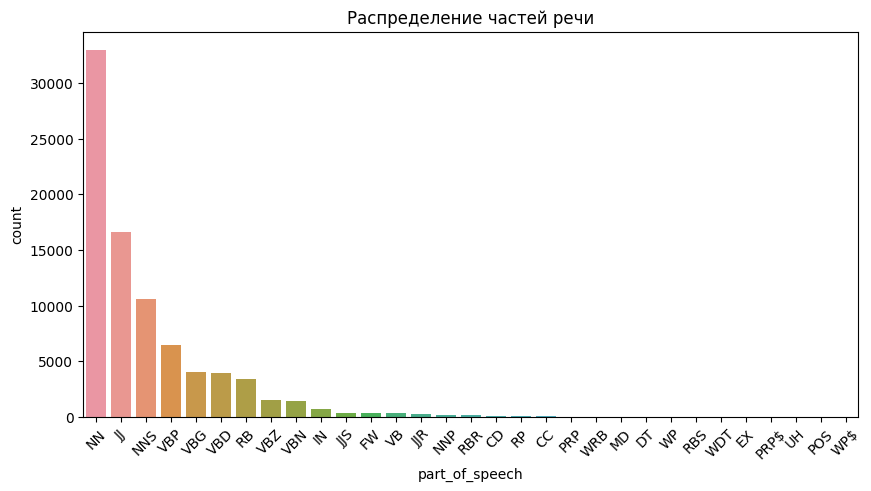

In [115]:
plt.figure(figsize=(10, 5))
sns.barplot(x=df_pos['part_of_speech'], y=df_pos['count'])
plt.xticks(rotation=45)
plt.title('Распределение частей речи')
plt.show()

# Частотный анализ слов

In [59]:
# подсчет кол-ва каждого слова
def frequency_words(text):
    words = [word.lower() for word in text if word.isalpha()]
    count_words = sorted(Counter(words).items(), key=lambda x: x[1], reverse=True)
    return count_words

In [60]:
data_100['frequency_words'] = data_100['without_stopwords'].apply(frequency_words)

/tmp/ipykernel_30/2796331881.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_100['frequency_words'] = data_100['without_stopwords'].apply(frequency_words)


In [122]:
words_all = []
for list_of_word in data_100['without_stopwords']:
    words_all.extend(list_of_word)

In [123]:
words_all_count = Counter(words_all)
df_all_words = pd.DataFrame(sorted(words_all_count.items(), key=lambda x: x[1], reverse=True), columns=['word', 'count'])

In [127]:
df_all_words_10 = df_all_words.iloc[:10]

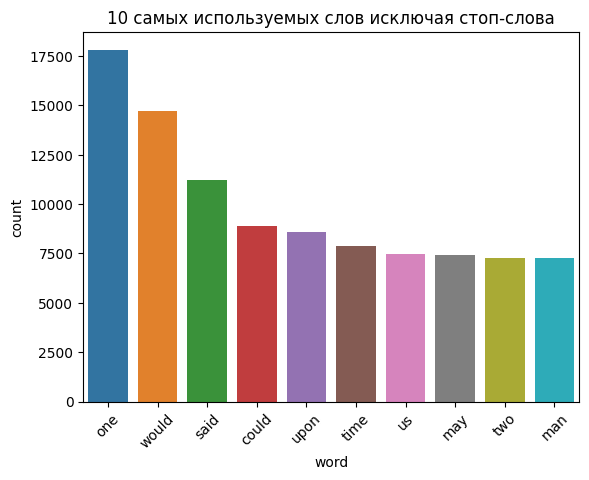

In [131]:
# plt.figure(figsize=(10, 5))
sns.barplot(x=df_all_words_10['word'], y=df_all_words_10['count'])
plt.xticks(rotation=45)
plt.title('10 самых используемых слов исключая стоп-слова')
plt.show()

In [61]:
data_100['frequency_words']

4878    [(one, 329), (would, 214), (may, 145), (say, 1...
5832    [(said, 963), (one, 274), (would, 247), (well,...
923     [(said, 544), (bill, 476), (antony, 466), (cay...
2470    [(one, 158), (hypnotism, 157), (subject, 150),...
5308    [(one, 280), (woman, 278), (may, 252), (let, 2...
                              ...                        
1498    [(e, 728), (il, 459), (che, 400), (di, 354), (...
267     [(e, 709), (la, 390), (di, 353), (il, 281), (c...
271     [(e, 591), (di, 361), (il, 336), (che, 287), (...
7754    [(mcclellan, 464), (seward, 391), (people, 297...
7889    [(seward, 299), (people, 265), (army, 264), (l...
Name: frequency_words, Length: 100, dtype: object

# Частотный n-граммный анализ

In [62]:
def ngramma(without_stopwords, n=2):
    ngram_words = [ngram for words in without_stopwords for ngram in ngrams(words, n)]
    counts = Counter(ngram_words)
    sort = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(sort, columns=['n-gram', 'frequency'])
    return df
    

In [63]:
# биграмма
df_2gram = ngramma(data_100['without_stopwords'], n=2)
df_2gram

,n-gram,frequency
0,"(united, states)",1935
1,"(new, york)",756
2,"(let, us)",601
3,"(executive, mansion)",534
4,"(footnote, footnote)",533
...,...,...
1671332,"(proofs, annoyed)",1
1671333,"(annoyed, author)",1
1671334,"(author, make)",1
1671335,"(brief, explanation)",1


In [77]:
df_2gram_10 = df_2gram.iloc[:10]

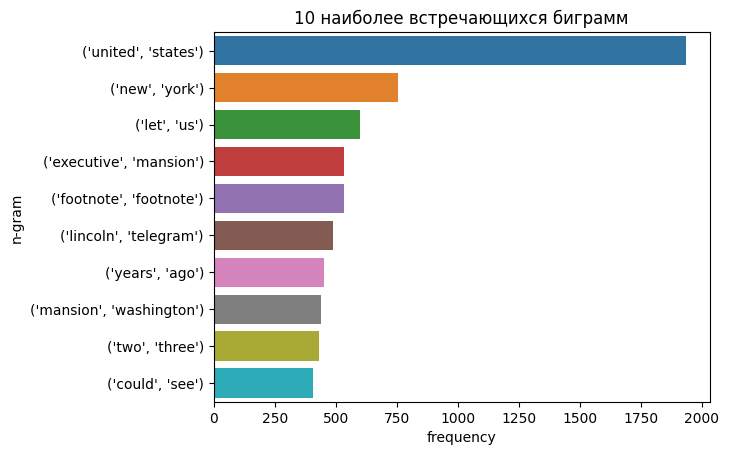

In [78]:
sns.barplot(x=df_2gram_10['frequency'], y=df_2gram_10['n-gram'])
plt.title('10 наиболее встречающихся биграмм')
plt.show()

In [64]:
# триграмма
df_3gram = ngramma(data_100['without_stopwords'], n=3)
df_3gram

,n-gram,frequency
0,"(executive, mansion, washington)",440
1,"(p, illustration, fig)",314
2,"(lincoln, telegram, general)",300
3,"(footnote, footnote, footnote)",279
4,"(president, united, states)",237
...,...,...
2322845,"(proofs, annoyed, author)",1
2322846,"(annoyed, author, make)",1
2322847,"(author, make, brief)",1
2322848,"(make, brief, explanation)",1


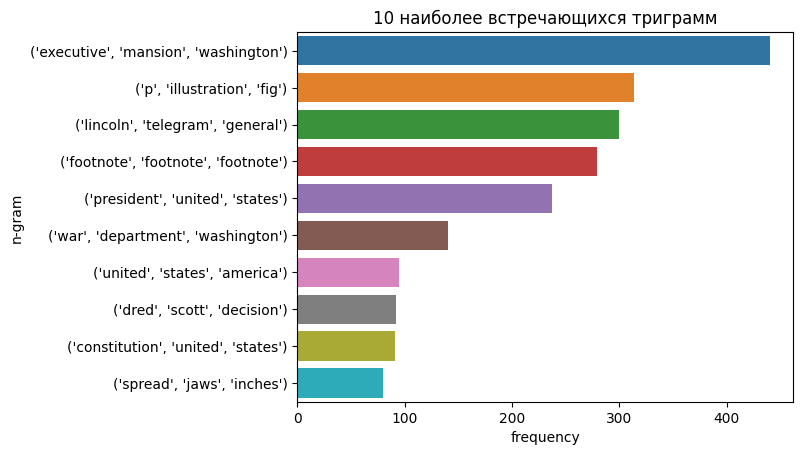

In [79]:
df_3gram_10 = df_3gram.iloc[:10]
sns.barplot(x=df_3gram_10['frequency'], y=df_3gram_10['n-gram'])
plt.title('10 наиболее встречающихся триграмм')
plt.show()

In [70]:
data_100['word_count'] = data_100['without_stopwords'].apply(len)

/tmp/ipykernel_30/2203007486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_100['word_count'] = data_100['without_stopwords'].apply(len)


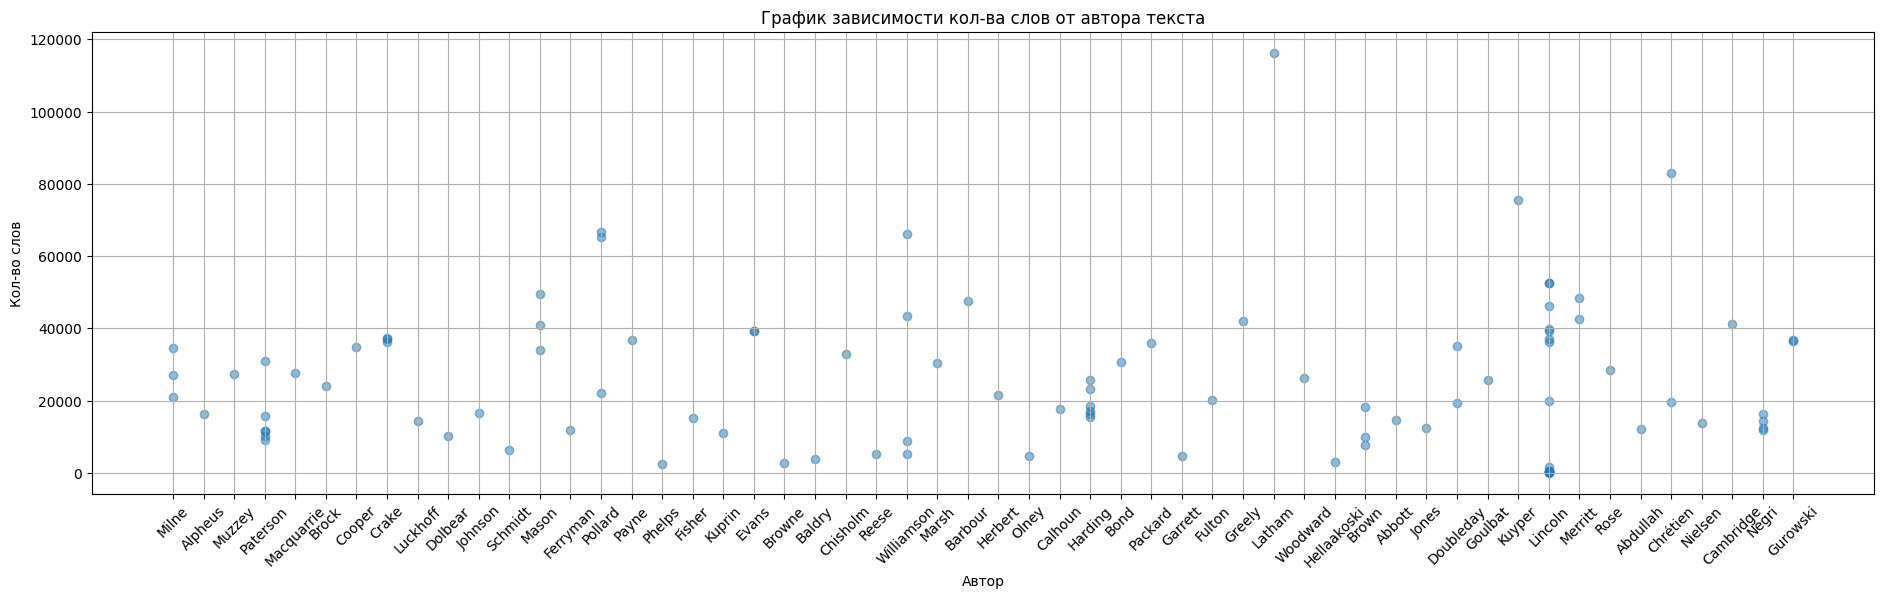

In [197]:
plt.figure(figsize=(23, 6))
plt.scatter(data_100['author_sn'], data_100['word_count'], alpha=0.5)
plt.title('График зависимости кол-ва слов от автора текста')
plt.xlabel('Автор')
plt.ylabel('Кол-во слов')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Подсчет знаков препинания

In [159]:
def punctuation(text):
    count_punct = len(re.findall(r'[^\w\s]', text))
    return count_punct

In [161]:
data_100['count_punctuation'] = data_100['cleaned_from_html'].apply(punctuation)

/tmp/ipykernel_30/1748520662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_100['count_punctuation'] = data_100['cleaned_from_html'].apply(punctuation)


,author,author_sn,title,text,FileName,is_gutenberg,without_stopwords,frequency_words,POS,word_count,count_punctuation,freq_punctuation,cleaned_from_html
4878,A_A_Milne,Milne,Not_That_It_Matters,"Scanned by Charles Aldarondo, text proof read ...",A_A_Milne-Not_That_It_Matters.txt,1,"[scanned, charles, aldarondo, text, proof, rea...","[(one, 329), (would, 214), (may, 145), (say, 1...","[(scanned, VBN), (charles, NNS), (aldarondo, V...",21010,7758,"{',': 2572, '(': 110, ':': 20, '/': 4, '.': 24...","Scanned by Charles Aldarondo, text proof read ..."
5832,A_A_Milne,Milne,Once_A_Week,"Produced by Malcolm Farmer, Stephen Blundell a...",A_A_Milne-Once_A_Week.txt,1,"[produced, malcolm, farmer, stephen, blundell,...","[(said, 963), (one, 274), (would, 247), (well,...","[(produced, VBN), (malcolm, JJ), (farmer, NN),...",34460,24370,"{',': 5199, ':': 40, '/': 33, '.': 6701, '(': ...","Produced by Malcolm Farmer, Stephen Blundell a..."
923,A_A_Milne,Milne,The_Red_House_Mystery,THE RED HOUSE MYSTERY By A. A. Milne TO...,a_A_Milne-The_Red_House_Mystery.txt,0,"[red, house, mystery, milne, john, vine, milne...","[(said, 544), (bill, 476), (antony, 466), (cay...","[(red, JJ), (house, NN), (mystery, NN), (milne...",27217,18773,"{'.': 5114, ',': 4578, ':': 26, '?': 969, '""':...",THE RED HOUSE MYSTERY By A. A. Milne TO...
2470,A_Alpheus,Alpheus,Complete_Hypnotism,MIND-READING AND SPIRITUALISM*** E-text prep...,a_Alpheus-Complete_Hypnotism.txt,0,"[prepared, jerry, kuntz, part, lawson, progres...","[(one, 158), (hypnotism, 157), (subject, 150),...","[(prepared, JJ), (jerry, NN), (kuntz, VB), (pa...",16221,5478,"{'-': 500, '*': 13, ''': 244, ':': 98, ',': 22...",MIND-READING AND SPIRITUALISM*** E-text prep...
5308,A_B_Muzzey,Muzzey,The_Young_Maiden,E-text prepared by Roger Frank and the Project...,A_B_Muzzey-The_Young_Maiden.txt,1,"[prepared, roger, frank, project, gutenberg, o...","[(one, 280), (woman, 278), (may, 252), (let, 2...","[(prepared, JJ), (roger, NN), (frank, NN), (pr...",27373,10469,"{'-': 410, '(': 1, ':': 18, '/': 2, '.': 2815,...",E-text prepared by Roger Frank and the Project...


In [162]:
def punctuation_frec(text):
    count_punct = re.findall(r'[^\w\s]', text)
    return Counter(count_punct)

In [163]:
data_100['freq_punctuation'] = data_100['cleaned_from_html'].apply(punctuation_frec)

/tmp/ipykernel_30/2363559807.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_100['freq_punctuation'] = data_100['cleaned_from_html'].apply(punctuation_frec)


,author,author_sn,title,text,FileName,is_gutenberg,without_stopwords,frequency_words,POS,word_count,count_punctuation,freq_punctuation,cleaned_from_html
4878,A_A_Milne,Milne,Not_That_It_Matters,"Scanned by Charles Aldarondo, text proof read ...",A_A_Milne-Not_That_It_Matters.txt,1,"[scanned, charles, aldarondo, text, proof, rea...","[(one, 329), (would, 214), (may, 145), (say, 1...","[(scanned, VBN), (charles, NNS), (aldarondo, V...",21010,7758,"{',': 2572, '(': 110, ':': 20, '/': 4, '.': 24...","Scanned by Charles Aldarondo, text proof read ..."
5832,A_A_Milne,Milne,Once_A_Week,"Produced by Malcolm Farmer, Stephen Blundell a...",A_A_Milne-Once_A_Week.txt,1,"[produced, malcolm, farmer, stephen, blundell,...","[(said, 963), (one, 274), (would, 247), (well,...","[(produced, VBN), (malcolm, JJ), (farmer, NN),...",34460,24370,"{',': 5199, ':': 40, '/': 33, '.': 6701, '(': ...","Produced by Malcolm Farmer, Stephen Blundell a..."
923,A_A_Milne,Milne,The_Red_House_Mystery,THE RED HOUSE MYSTERY By A. A. Milne TO...,a_A_Milne-The_Red_House_Mystery.txt,0,"[red, house, mystery, milne, john, vine, milne...","[(said, 544), (bill, 476), (antony, 466), (cay...","[(red, JJ), (house, NN), (mystery, NN), (milne...",27217,18773,"{'.': 5114, ',': 4578, ':': 26, '?': 969, '""':...",THE RED HOUSE MYSTERY By A. A. Milne TO...
2470,A_Alpheus,Alpheus,Complete_Hypnotism,MIND-READING AND SPIRITUALISM*** E-text prep...,a_Alpheus-Complete_Hypnotism.txt,0,"[prepared, jerry, kuntz, part, lawson, progres...","[(one, 158), (hypnotism, 157), (subject, 150),...","[(prepared, JJ), (jerry, NN), (kuntz, VB), (pa...",16221,5478,"{'-': 500, '*': 13, ''': 244, ':': 98, ',': 22...",MIND-READING AND SPIRITUALISM*** E-text prep...
5308,A_B_Muzzey,Muzzey,The_Young_Maiden,E-text prepared by Roger Frank and the Project...,A_B_Muzzey-The_Young_Maiden.txt,1,"[prepared, roger, frank, project, gutenberg, o...","[(one, 280), (woman, 278), (may, 252), (let, 2...","[(prepared, JJ), (roger, NN), (frank, NN), (pr...",27373,10469,"{'-': 410, '(': 1, ':': 18, '/': 2, '.': 2815,...",E-text prepared by Roger Frank and the Project...


In [164]:
data_100['freq_punctuation']

4878    {',': 2572, '(': 110, ':': 20, '/': 4, '.': 24...
5832    {',': 5199, ':': 40, '/': 33, '.': 6701, '(': ...
923     {'.': 5114, ',': 4578, ':': 26, '?': 969, '"':...
2470    {'-': 500, '*': 13, ''': 244, ':': 98, ',': 22...
5308    {'-': 410, '(': 1, ':': 18, '/': 2, '.': 2815,...
                              ...                        
1498    {'-': 544, ',': 1845, '*': 19, '.': 4822, ''':...
267     {'-': 506, ',': 1533, '.': 4277, ''': 778, '«'...
271     {'-': 453, ',': 1353, '*': 21, '.': 3680, ''':...
7754    {'-': 3552, ',': 6303, '.': 4068, '(': 73, ':'...
7889    {',': 6561, '.': 4618, ':': 100, '/': 2, '(': ...
Name: freq_punctuation, Length: 100, dtype: object

In [165]:
all_punctuation = Counter()
for d in data_100['freq_punctuation']:
    all_punctuation.update(d)
    
df_punctuations = pd.DataFrame.from_dict(dict(all_punctuation), orient='index', columns=['count'])
df_punctuations = df_punctuations.sort_values(by='count', ascending=False)
df_punctuations.reset_index(inplace=True)

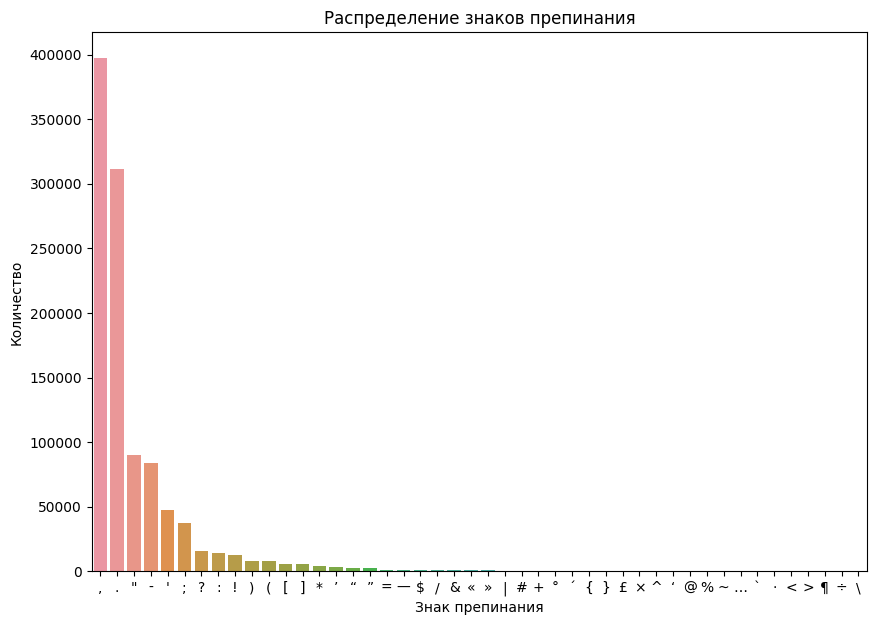

In [166]:
plt.figure(figsize=(10, 7))
sns.barplot(x=df_punctuations['index'], y=df_punctuations['count'])
plt.title('Распределение знаков препинания')
plt.xlabel('Знак препинания')
plt.ylabel('Количество')
plt.show()

# Лемматизация слов

In [186]:
nlp = spacy.load("en_core_web_sm")

def lemma(text):
    doc = nlp(" ".join(text))
    lem_words = [token.lemma_ for token in doc]
    return lem_words

In [191]:
data_20 = data_100.iloc[:20]

In [192]:
data_20['lematised_words'] = data_20['without_stopwords'].apply(lemma)

/tmp/ipykernel_30/2169436413.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_20['lematised_words'] = data_20['without_stopwords'].apply(lemma)


In [194]:
data_20.head()

,author,author_sn,title,text,FileName,is_gutenberg,without_stopwords,frequency_words,POS,word_count,count_punctuation,freq_punctuation,cleaned_from_html,lematised_words
4878,A_A_Milne,Milne,Not_That_It_Matters,"Scanned by Charles Aldarondo, text proof read ...",A_A_Milne-Not_That_It_Matters.txt,1,"[scanned, charles, aldarondo, text, proof, rea...","[(one, 329), (would, 214), (may, 145), (say, 1...","[(scanned, VBN), (charles, NNS), (aldarondo, V...",21010,7758,"{',': 2572, '(': 110, ':': 20, '/': 4, '.': 24...","Scanned by Charles Aldarondo, text proof read ...","[scan, charles, aldarondo, text, proof, read, ..."
5832,A_A_Milne,Milne,Once_A_Week,"Produced by Malcolm Farmer, Stephen Blundell a...",A_A_Milne-Once_A_Week.txt,1,"[produced, malcolm, farmer, stephen, blundell,...","[(said, 963), (one, 274), (would, 247), (well,...","[(produced, VBN), (malcolm, JJ), (farmer, NN),...",34460,24370,"{',': 5199, ':': 40, '/': 33, '.': 6701, '(': ...","Produced by Malcolm Farmer, Stephen Blundell a...","[produce, malcolm, farmer, stephen, blundell, ..."
923,A_A_Milne,Milne,The_Red_House_Mystery,THE RED HOUSE MYSTERY By A. A. Milne TO...,a_A_Milne-The_Red_House_Mystery.txt,0,"[red, house, mystery, milne, john, vine, milne...","[(said, 544), (bill, 476), (antony, 466), (cay...","[(red, JJ), (house, NN), (mystery, NN), (milne...",27217,18773,"{'.': 5114, ',': 4578, ':': 26, '?': 969, '""':...",THE RED HOUSE MYSTERY By A. A. Milne TO...,"[red, house, mystery, milne, john, vine, milne..."
2470,A_Alpheus,Alpheus,Complete_Hypnotism,MIND-READING AND SPIRITUALISM*** E-text prep...,a_Alpheus-Complete_Hypnotism.txt,0,"[prepared, jerry, kuntz, part, lawson, progres...","[(one, 158), (hypnotism, 157), (subject, 150),...","[(prepared, JJ), (jerry, NN), (kuntz, VB), (pa...",16221,5478,"{'-': 500, '*': 13, ''': 244, ':': 98, ',': 22...",MIND-READING AND SPIRITUALISM*** E-text prep...,"[prepare, jerry, kuntz, part, lawson, progress..."
5308,A_B_Muzzey,Muzzey,The_Young_Maiden,E-text prepared by Roger Frank and the Project...,A_B_Muzzey-The_Young_Maiden.txt,1,"[prepared, roger, frank, project, gutenberg, o...","[(one, 280), (woman, 278), (may, 252), (let, 2...","[(prepared, JJ), (roger, NN), (frank, NN), (pr...",27373,10469,"{'-': 410, '(': 1, ':': 18, '/': 2, '.': 2815,...",E-text prepared by Roger Frank and the Project...,"[prepared, roger, frank, project, gutenberg, o..."
